In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import imutils
import dlib
from imutils import face_utils
import math 
from typing import NewType
from skimage.measure import compare_ssim
from skimage.transform import resize
from scipy.stats import wasserstein_distance

NumpyArray = NewType("NumpyArray", np.ndarray)
cv.__version__

'4.2.0'

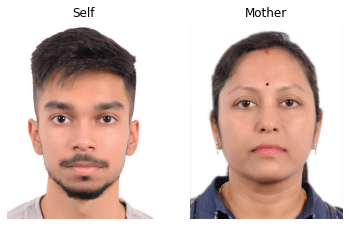

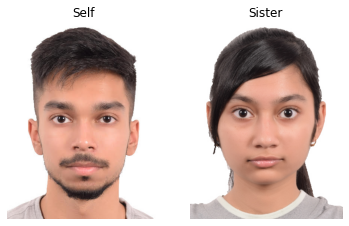

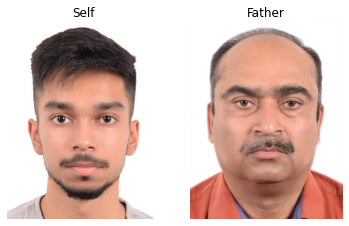

In [2]:
image1 = cv.imread("./photo/me.jpg")
image2 = cv.imread("./photo/mother.JPG")
image3 = cv.imread("./photo/sister.JPG")
image4 = cv.imread("./photo/father.JPG")

im1Gray = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)
im2Gray = cv.cvtColor(image2, cv.COLOR_BGR2GRAY)
im3Gray = cv.cvtColor(image3, cv.COLOR_BGR2GRAY)
im4Gray = cv.cvtColor(image4, cv.COLOR_BGR2GRAY)

def plotColor(image1, image2, title1, title2):
    plt.subplot(121)
    plt.axis('off')
    plt.title(title1)
    plt.imshow(cv.cvtColor(image1, cv.COLOR_BGR2RGB))

    plt.subplot(122)
    plt.axis('off')
    plt.imshow(cv.cvtColor(image2, cv.COLOR_BGR2RGB))
    plt.title(title2)
    plt.show()

plotColor(image1, image2, "Self", "Mother")
plotColor(image1, image3, "Self", "Sister")
plotColor(image1, image4, "Self", "Father")
names = ["Self", "Mother", "Sister", "Father"]

In [3]:
# Download predictor from: dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

predictorPath = "./shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictorPath)

images = [image1, image2, image3, image4]
rects = []

for image in images:
    rects.append(detector(image, 1))
rects[0]

rectangles[[(82, 171) (349, 439)]]

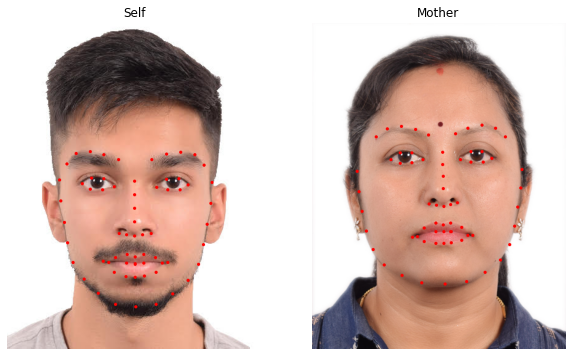

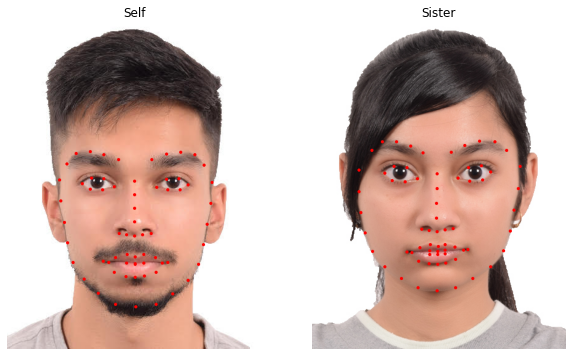

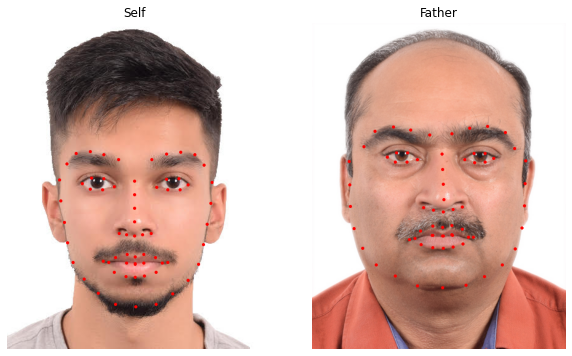

In [4]:
grayImages = [im1Gray, im2Gray, im3Gray, im4Gray]

def getAndMapFeatures(gray: NumpyArray, image: NumpyArray, rects):
    points = []
    for (i, rect) in enumerate(rects):
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        points = shape

        for (x, y) in shape:
            cv.circle(image, (x, y), 1, (0, 0, 255), 2)
    return image, points

featuresAndPoints = []

for image, gray, rect in zip(images, grayImages, rects):
    imFeatures, points = getAndMapFeatures(gray, image, rect)
    featuresAndPoints.append((imFeatures, points))

matplotlib.rcParams['figure.figsize'] = (10, 10)
selfFeatures = featuresAndPoints[0][0]

for i in range(1, len(featuresAndPoints)):
    plotColor(selfFeatures, featuresAndPoints[i][0], "Self", names[i]) 


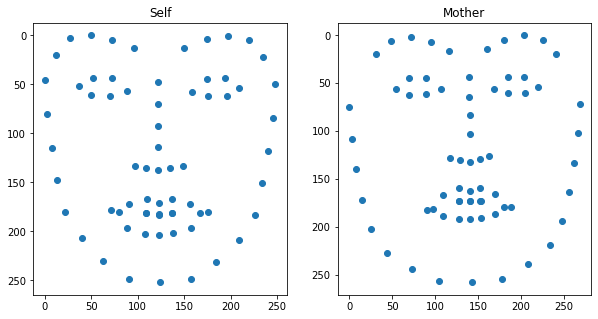

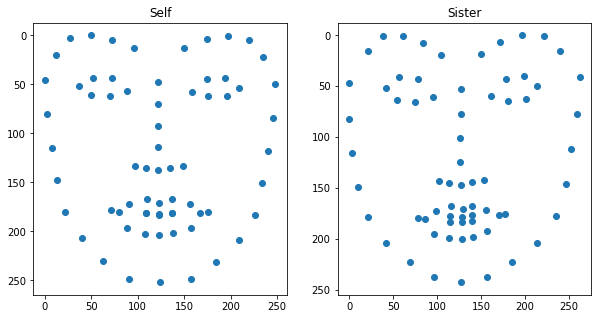

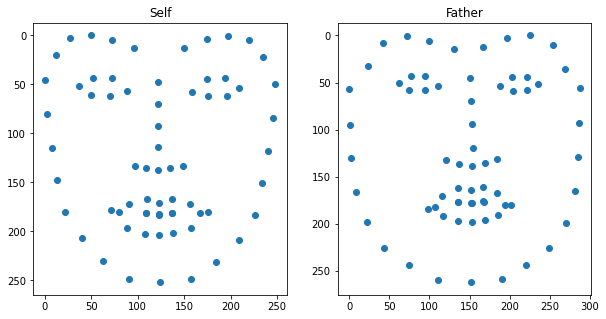

In [5]:
# We need to normalize points since lowest value of x coordinate in facial features
# may change from face to face. This is will lead to wrong calculation of
# euclidian distance between those points. For example a persons eyebrows may be 
# located higher but it should not affect the similarity

def scalePoints(points: NumpyArray)->NumpyArray:
    # Lowest x and y coordinates
    xl, yl = np.min(points[:, 0]), np.min(points[:, 1])
    m, n = points.shape
    for i in range(points.shape[0]):
        points[i][0]-=xl
        points[i][1]-=yl
    return points

scaledPoints = []
for i in featuresAndPoints:
    scaledPoints.append(scalePoints(i[1]))

matplotlib.rcParams['figure.figsize'] = (10, 5)

def plotPoints(points1, points2, title1, title2):
    plt.subplot(121)
    plt.gca().invert_yaxis()
    plt.scatter(points1[:, 0], points1[:, 1])
    plt.title(title1)

    plt.subplot(122)
    plt.gca().invert_yaxis()
    plt.scatter(points2[:, 0], points2[:, 1])
    plt.title(title2)

selfPoints = scaledPoints[0]
for i in range(1, len(scaledPoints)):
    plotPoints(selfPoints, scaledPoints[i], "Self", names[i])
    plt.show()

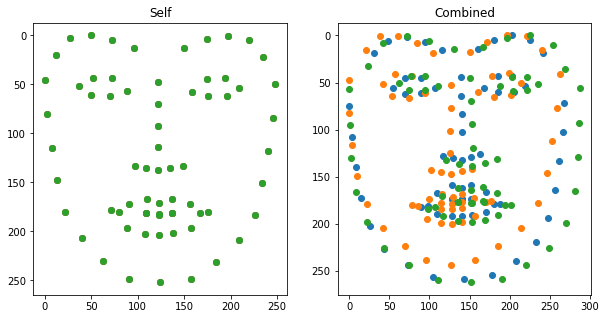

In [6]:
for i in range(1, len(scaledPoints)):
    plotPoints(selfPoints, scaledPoints[i], "Self", "Combined")
plt.show()

In [7]:
def scaledManhatthanDistance(points1: NumpyArray, points2: NumpyArray) -> float:
  if points1.shape != points2.shape:
    raise "Shape mismatch in points"
  val = 0
  n, m = points1.shape
  val = np.sum(np.absolute(points1 - points2)) / (points1.shape[0]*points1.shape[1])
  return val

selfPoints = scaledPoints[0]

print("Manhattan Distance\n")
for i in range(0, len(scaledPoints)):
    val = scaledManhatthanDistance(selfPoints, scaledPoints[i])
    print("Self & {}: {:.6f}".format(names[i], val))

Manhattan Distance

Self & Self: 0.000000
Self & Mother: 11.382353
Self & Sister: 4.610294
Self & Father: 16.102941


In [8]:
# https://www.sciencedirect.com/topics/computer-science/normalized-correlation
def getHistogram(img):
  h, w = img.shape
  hist = [0.0] * 256
  for i in range(h):
    for j in range(w):
      hist[img[i, j]] += 1
  return np.array(hist) / (h * w)

hists = []
for gray in grayImages:
  hists.append(getHistogram(gray))

selfHist = hists[0]

print("Earth Movers distance\n")
for i in range(len(hists)):
  emDistance = wasserstein_distance(selfHist, hists[i])
  print("Self & {}: {:.6f}".format(names[i], emDistance))

Earth Movers distance

Self & Self: 0.000000
Self & Mother: 0.000810
Self & Sister: 0.000378
Self & Father: 0.001752


In [9]:
# SSIM
print("SSIM\n")
selfImage = images[0]
for i in range(len(images)):
    val = compare_ssim(selfImage, images[i], multichannel=True)
    print("Self & {}: {:.6f}".format(names[i], val))

SSIM

Self & Self: 1.000000
Self & Mother: 0.538413
Self & Sister: 0.562699
Self & Father: 0.460827


In [10]:
def sift_sim(img_a, img_b):
  # initialize the sift feature detector
  orb = cv.ORB_create()

  # find the keypoints and descriptors with SIFT
  kp_a, desc_a = orb.detectAndCompute(img_a, None)
  kp_b, desc_b = orb.detectAndCompute(img_b, None)

  # initialize the bruteforce matcher
  bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

  # match.distance is a float between {0:100} - lower means more similar
  matches = bf.match(desc_a, desc_b)
  similar_regions = [i for i in matches if i.distance < 70]
  if len(matches) == 0:
    return 0
  return len(similar_regions) / len(matches)

print("SIFT SIM\n")
for i in range(len(images)):
    val = sift_sim(selfImage, images[i])
    print("Self & {}: {:.6f}".format(names[i], val))

SIFT SIM

Self & Self: 1.000000
Self & Mother: 0.983607
Self & Sister: 0.984962
Self & Father: 0.959459


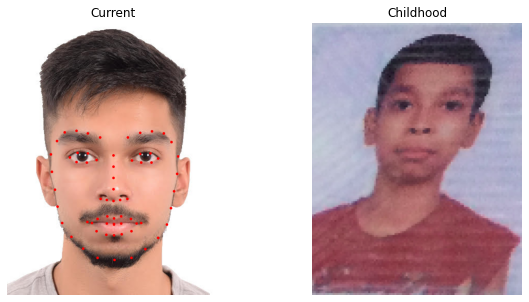

In [11]:
image5 = cv.imread("./photo/Self2.png")
image6 = cv.imread("./photo/Self3.png")

im5Gray = cv.cvtColor(image5, cv.COLOR_BGR2GRAY)
im6Gray = cv.cvtColor(image6, cv.COLOR_BGR2GRAY)
plotColor(image1, image5, "Current", "Childhood")

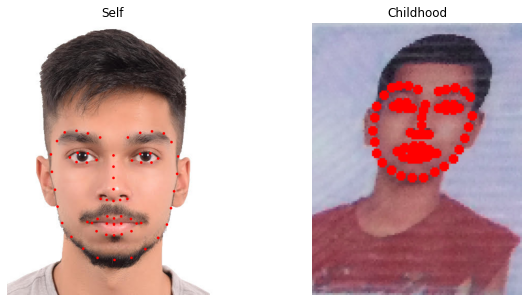

In [12]:
rect = detector(image5, 1)
features, points = getAndMapFeatures(im5Gray, image5, rect)
plotColor(selfFeatures, features, "Self", "Childhood")

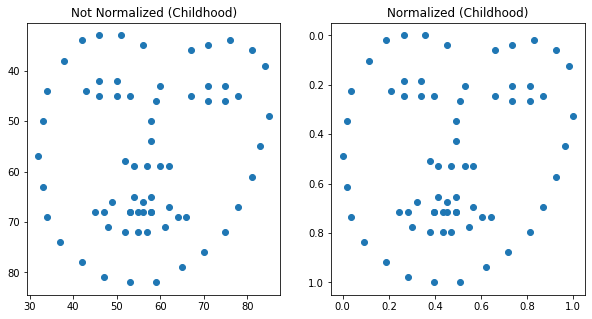

In [13]:
# Normalize all distances to range [0, 1]
def normalizePoints(points):
    x = (points[:, 0] - min(points[:, 0]))/(max(points[:, 0])- min(points[:, 0]))
    y = (points[:, 1] - min(points[:, 1]))/(max(points[:, 1])- min(points[:, 1]))
    x = np.array(x)
    y = np.array(y)
    return np.vstack((x, y)).T
normalizedPoints = normalizePoints(points) 

# Normalized points have similar distance between features as original
# This helps us compensate for the difference in resolution of images

# This also helps to fix the orientation (skewness) by a bit
plotPoints(points, normalizedPoints, "Not Normalized (Childhood)", "Normalized (Childhood)")

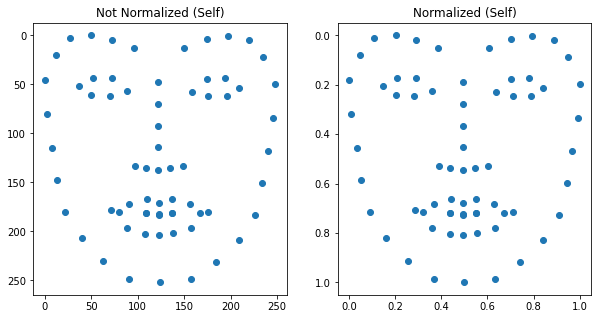

In [14]:
selfNormalizedPoints = normalizePoints(selfPoints)
plotPoints(selfPoints, selfNormalizedPoints, "Not Normalized (Self)", "Normalized (Self)")

In [15]:
print("Manhattan Distance: {:.6f}".format(scaledManhatthanDistance(selfNormalizedPoints, normalizedPoints)))
childhoodHist = getHistogram(im5Gray)
print("Earth Movers Distance: {:.6f}".format(wasserstein_distance(selfHist, childhoodHist)))
print("SIFT SIM: ", sift_sim(selfImage, image5))

Manhattan Distance: 0.035612
Earth Movers Distance: 0.003296
SIFT SIM:  0.72


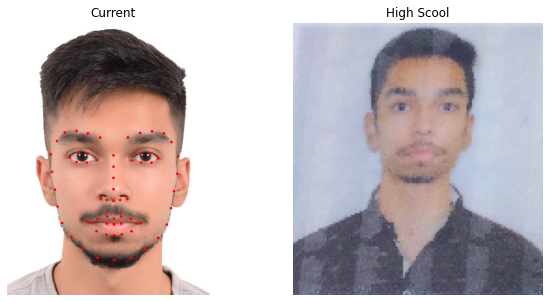

In [16]:
plotColor(image1, image6, "Current", "High Scool")

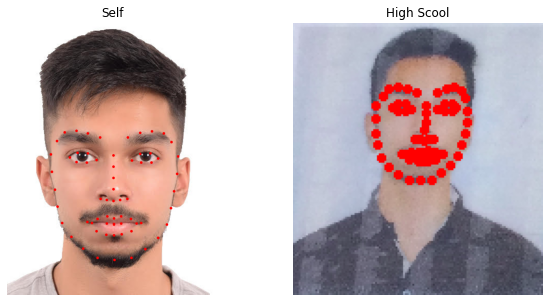

In [17]:
rect = detector(image6, 1)
features, points = getAndMapFeatures(im6Gray, image6, rect)
plotColor(selfFeatures, features, "Self", "High Scool")

In [18]:
normalizedPoints = normalizePoints(points) 
print("Manhattan Distance: {:.6f}".format(scaledManhatthanDistance(selfNormalizedPoints, normalizedPoints)))
highschoolHist = getHistogram(im6Gray)
print("Earth Movers Distance: {:.6f}".format(wasserstein_distance(selfHist, highschoolHist)))
print("SIFT SIM: ", sift_sim(selfImage, image6))

Manhattan Distance: 0.023204
Earth Movers Distance: 0.003396
SIFT SIM:  0.9
